In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import jax
from jaxmarl import make
from jaxmarl.environments.mpe import MPEVisualizer
from IPython.display import HTML

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:

import jax
from jaxmarl import make
from jaxmarl.viz.overcooked_visualizer import OvercookedVisualizer
from jaxmarl.environments.overcooked import overcooked_layouts, Actions
import time
import jax.numpy as jnp


In [4]:
#random key
key = jax.random.PRNGKey(42)
key, key_r, key_a = jax.random.split(key, 3)

In [5]:
layout = overcooked_layouts["cramped_room"]
max_steps = 100
env = make('overcooked', layout=layout, max_steps=max_steps, check_held_out=False)

obs, state = env.reset(key_r)
#obs, state = env.custom_reset(key_r, random_reset=True, shuffle_inv_and_pot=False, layout=layout)
print(f'Agents in environment: {env.agents}')
print(f'Number of agents: {env.num_agents}')

Agents in environment: ['agent_0', 'agent_1']
Number of agents: 2


In [6]:
print(env.agents[0])


agent_0


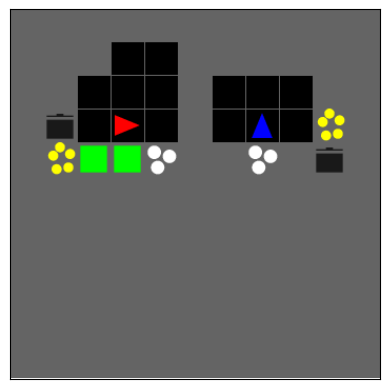

Initial render complete
next
Step 1 complete
Step 2 complete
Step 3 complete
Step 4 complete
Step 5 complete
Step 6 complete
Step 7 complete
Step 8 complete
Step 9 complete
Step 10 complete
Done


In [8]:
import time
import matplotlib.pyplot as plt
import types

viz = OvercookedVisualizer()

# Patch the show_img method BEFORE using it
def force_update_show_img(self, img):
    """Force update the image display with proper redraw"""
    if self.imshow_obj is None:
        self.imshow_obj = self.ax.imshow(img, interpolation='bilinear')
        self.ax.set_xlim(0, img.shape[1])
        self.ax.set_ylim(img.shape[0], 0)
    else:
        # Clear and redraw for more reliable updates
        self.imshow_obj.remove()
        self.imshow_obj = self.ax.imshow(img, interpolation='bilinear')
    
    # Force multiple redraw methods
    self.fig.canvas.draw()
    self.fig.canvas.flush_events()
    self.fig.canvas.draw_idle()
    plt.pause(0.2)  # Longer pause

# Apply the patch
viz._lazy_init_window()  # Initialize window first
viz.window.show_img = types.MethodType(force_update_show_img, viz.window)

# Now use the visualizer
state_seq = [state]
action_seq = [actions] if 'actions' in locals() else [{agent: 0 for agent in env.agents}]
reward_seq = [{agent: 0.0 for agent in env.agents}] 

current_state = state 

# Render first frame
viz.render(env.agent_view_size, current_state)
plt.ion()
if viz.window is not None:
    viz.window.fig.show()
plt.pause(0.5)

print("Initial render complete")
time.sleep(2)
print("next")

for i in range(10):
    actions = {
        env.agents[0]: Actions.right,
        env.agents[1]: Actions.right
    }
    
    key, key_s, key_a = jax.random.split(key, 3)
    obs, next_state, rewards, dones, infos = env.step(key_s, current_state, actions)
    
    current_state = next_state
    state_seq.append(next_state)
    action_seq.append(actions)
    reward_seq.append(rewards)
    
    viz.render(env.agent_view_size, next_state)
    time.sleep(0.5)
    print(f"Step {i+1} complete")

print("Done")

list of agents in environment ['agent_0', 'agent_1']
example action dict {'agent_0': Array(4, dtype=uint32), 'agent_1': Array(5, dtype=uint32)}


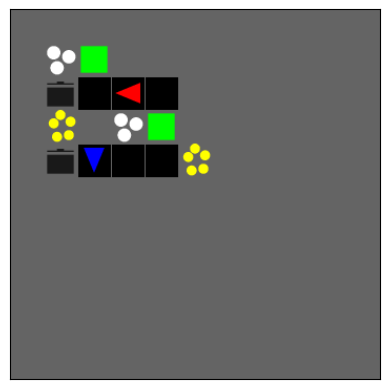

In [16]:

import jax 
from jaxmarl import make
from jaxmarl.viz.overcooked_visualizer import OvercookedVisualizer
from jaxmarl.environments.overcooked import Overcooked, overcooked_layouts, layout_grid_to_dict
import time

# Parameters + random keys
max_steps = 100
key = jax.random.PRNGKey(0)
key, key_r, key_a = jax.random.split(key, 3)

# Get one of the classic layouts (cramped_room, asymm_advantages, coord_ring, forced_coord, counter_circuit)
layout = overcooked_layouts["cramped_room"]

# Or make your own!
# custom_layout_grid = """
# WWOWW
# WA  W
# B P X
# W  AW
# WWOWW
# """
# layout = layout_grid_to_dict(custom_layout_grid)

# Instantiate environment
env = make('overcooked', layout=layout, max_steps=max_steps)

obs, state = env.reset(key_r)
print('list of agents in environment', env.agents)

# Sample random actions
key_a = jax.random.split(key_a, env.num_agents)
actions = {agent: env.action_space(agent).sample(key_a[i]) for i, agent in enumerate(env.agents)}
print('example action dict', actions)

state_seq = []
for _ in range(max_steps):
    state_seq.append(state)
    # Iterate random keys and sample actions
    key, key_s, key_a = jax.random.split(key, 3)
    key_a = jax.random.split(key_a, env.num_agents)

    actions = {agent: env.action_space(agent).sample(key_a[i]) for i, agent in enumerate(env.agents)}

    # Step environment
    obs, state, rewards, dones, infos = env.step(key_s, state, actions)

viz = OvercookedVisualizer()

# Render to screen
for s in state_seq:
    viz.render(env.agent_view_size, s, highlight=False)
    time.sleep(0.25)